# Análise de sentimento - positivo ou negativo na Base de filmes IMDB

## Introdução

A análise do sentimento é um problema de processamento de linguagem natural onde o texto é entendido e a intenção subjacente é prevista.

Este notebook contém um exemplo de predição do sentimento das avaliações de filmes como positivo ou negativo utilizando o Keras e
acessando a based de filmes IMDB. Esta é uma base pública contendo 25 mil amostras de treinamento e 25 mil amostras de teste.

O problema de análise de sentimento consiste em analisar um texto de revisão de filme e classificá-lo como revisão positiva ou negativa.

Houve uma competição no Kaggle, denominada "*Bag of Words Meets Bags of Popcorn*": https://www.kaggle.com/c/word2vec-nlp-tutorial
que trata justamente de análise de sentimento baseado neste mesmo dataset.

Iremos utilizar 3 soluções:
- rede neural clássica com embedding treinável e 1 camadas escondida
- rede convolucional com embedding treinável, uma convolucional e 2 camadas densas
- rede anterior, porém com embedding pré treinado com o word2vec Glove
- rede multiconvolucional com embedding pré treinado

## Importação das bibliotecas

In [26]:
%matplotlib inline
import os,sys
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, l1
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import get_file
from keras.datasets import imdb

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

In [2]:
import keras.backend as K
# K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []


## Funções de apoio ao treinamento

In [24]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura do Dataset IMDB

O Keras já possui este dataset para leitura. Ele é composto de 25 mil amostras de treinamento e 25 mil amostras de teste.
Cada amostra possui um texto de tamanho que varia entre 11 e 2494 palavras. Cada amostra tem um rótulo
associado com 1 para denominar sentimento positivo e 0 para sentimento negativo.

### Leitura dos textos de revisão e rótulos dos sentimentos

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)


Mostramos o número de amostras de treinamento e teste e 2 primeiros textos: o primeiro possui 218 palavras e sentimento positivo
enquanto que o segundo possui 189 palavras e sentimento negativo.
Observe que as palavras estão codificadas.

In [5]:
print(len(x_train),len(x_test))
for i in range(2):
    print('texto:',i,'(',len(x_train[i]),') -',y_train[i],':',x_train[i])

25000 25000
texto: 0 ( 218 ) - 1 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
t

### Leitura dos índices das palavras

O Keras traz junto uma função que carrega o índice das palavras. Este índice é baseado nas palavras mais frequentes, quanto mais frequente a
palavra, menor o seu índice. Isso facilita na hora de descartar palavras devido a um limite imposto no tamanho do vocabulário.

In [7]:
from keras.datasets import imdb
idx = imdb.get_word_index()
print('Número de palavras no índice:', len(idx))
idx2word = {v: k for k, v in idx.items()}
print('Quatro palavras mais frequentes:',[idx2word[i] for i in range(1,5)])

Número de palavras no índice: 88584
Quatro palavras mais frequentes: ['the', 'and', 'a', 'of']


### Visualizando o texto do primeiro comentário, que é positivo.

Muito cuidado: a conversão do índice para palavras possui offset de -3:
- 0 é reservado para padding;
- 1 é reservado para início sequência;
- 2 é reservado para palavras raras.
Utilizar como verificação: 'french' é iD: 785 

Entretanto, o texto não é utilizado no treinamento e predição da rede,
ele serve apenas para certificarmos sobre a integridade da base de dados.

In [8]:
' '.join([idx2word[o-3] for o in x_train[0][1:]])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

### Texto do segundo comentário, negativo

In [9]:
' '.join([idx2word[o-3] for o in x_train[1][1:]])

"big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

## Preparando o dataset

Existe dois ajustes necessários do dataset antes de colocá-lo na rede neural:
1. Tornar os textos de cada amostra com mesmo comprimento
2. Limitar o vocabulário 

### Textos com mesmo comprimento - truncar ou completar

Observa-se que o comprimento mínimo de palavras é 11, o máximo é 2494 e o valor médio é 238.
Assim, iremos utilizar um comprimento padrão de 500 palavras.

In [10]:
lens = np.array(list(map(len, x_train)))
(lens.min(), lens.max(), lens.mean())

(11, 2494, 238.71364)

A função `pad_sequences` do Keras trunca o texto em 500 palavras e caso o texto tenha
um número menor de palavras, ele é completado com os valores zero:

In [11]:
SEQ_LEN = 500

x_train_pad = sequence.pad_sequences(x_train, maxlen=SEQ_LEN+1, value=0,
                                     padding='post', 
                                     truncating='post')[:,1:] # eliminando primeiro código: 1
x_test_pad  = sequence.pad_sequences(x_test,  maxlen=SEQ_LEN+1, value=0, 
                                     padding='post', 
                                     truncating='post')[:,1:] # eliminando primeiro código: 1

In [12]:
print(x_train_pad[0])

[   14    22    16    43   530   973  1622  1385    65   458  4468    66
  3941     4   173    36   256     5    25   100    43   838   112    50
   670 22665     9    35   480   284     5   150     4   172   112   167
 21631   336   385    39     4   172  4536  1111    17   546    38    13
   447     4   192    50    16     6   147  2025    19    14    22     4
  1920  4613   469     4    22    71    87    12    16    43   530    38
    76    15    13  1247     4    22    17   515    17    12    16   626
    18 19193     5    62   386    12     8   316     8   106     5     4
  2223  5244    16   480    66  3785    33     4   130    12    16    38
   619     5    25   124    51    36   135    48    25  1415    33     6
    22    12   215    28    77    52     5    14   407    16    82 10311
     8     4   107   117  5952    15   256     4 31050     7  3766     5
   723    36    71    43   530   476    26   400   317    46     7     4
 12118  1029    13   104    88     4   381    15   

A vantagem é que agora os dados de treinamento estão na forma de um array (NumPy) contendo
25 mil amostras de 500 índices de palavras em cada amostra.

In [13]:
print(x_train_pad.shape)

(25000, 500)


### Limitando o vocabulário de 88.584 para 5000 palavras mais utilizadas

Existe muitas palavras de pouco uso que muitas vezes podem tornar a análise mais difícil.
É comum, portanto limitar o vocabulário, convertendo o código das palavras fora do vocabulário
como o último código.

In [14]:
VOCAB_SIZE = 5000

x_train_clip = np.clip(x_train_pad,0,VOCAB_SIZE-1)
x_test_clip  = np.clip(x_test_pad, 0,VOCAB_SIZE-1)

## Rede Neural clássica com uma única camada escondida

Utiliza-se aqui uma rede neural mínima, com uma única camada escondida e o embedding com 32 atributos a serem treinados, inicializados aleatóriamente.
Lembrar que o embedding é uma forma de entrar com dados categóricos que são trocados pelos seus atributos latentes, a serem treinados.

### Construindo a rede

In [15]:
model = Sequential([
    Embedding(VOCAB_SIZE, 32, input_length=SEQ_LEN),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1600100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,760,201
Trainable params: 1,760,201
Non-trainable params: 0
_________________________________________________________________


### Treinando a rede

[INFO] loading model...
[INFO] training for 49 epochs...


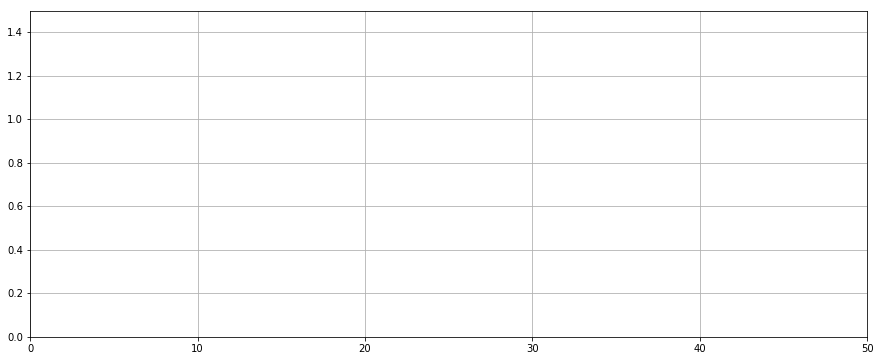

In [30]:
model_name = '../../models/SA_IMDB_1'
fit_params = {
    'model_name': model_name,
    'loss': 'binary_crossentropy',
    'opt':        Adam(),      #SGD(lr=0.001, momentum=0.9, nesterov=True), 
    'batch_size': 64, 
    'nepochs':    50,
    'patience':   15,
    'ploss':      1.5,
    'reset':      False,
}

train_network(model, x_train_clip, y_train, x_test_clip, y_test, **fit_params);

#model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#model.fit(x_train_clip, y_train, validation_data=(x_test_clip, y_test), epochs=1, batch_size=64)

### Avaliando a rede

In [31]:
test_network(model_name, x_test_clip, y_test)

Model from epoch 0
[INFO] evaluating in the test data set ...
24704/25000 [============================>.] - ETA: 0s 

The [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) that this dataset is from cites a state of the art accuracy (without unlabelled data) of 0.883. So we're short of that, but on the right track.

## Rede Convolucional com max pooling

A CNN is likely to work better, since it's designed to take advantage of ordered data. We'll need to use a 1D CNN, since a sequence of words is 1D.

In [32]:
conv1 = Sequential([
    Embedding(VOCAB_SIZE, 32, input_length=SEQ_LEN),
    keras.layers.SpatialDropout1D(0.2),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])
print(conv1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           10304     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1600100   
__________

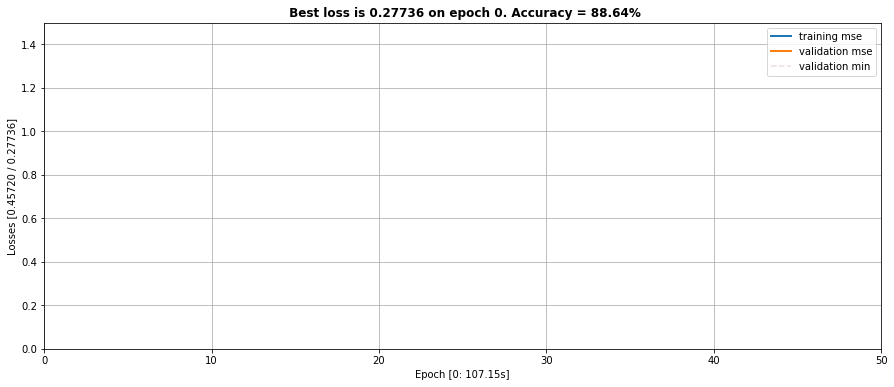

In [33]:
model_name = '../../models/SA_IMDB_conv1'
fit_params = {
    'model_name': model_name,
    'loss': 'binary_crossentropy',
    'opt':        Adam(),      #SGD(lr=0.001, momentum=0.9, nesterov=True), 
    'batch_size': 64, 
    'nepochs':    50,
    'patience':   15,
    'ploss':      1.5,
    'reset':      False,
}

train_network(conv1, x_train_clip, y_train, x_test_clip, y_test, **fit_params);


In [34]:
test_network(model_name, x_test_clip, y_test)

Model from epoch 0
[INFO] evaluating in the test data set ...
24960/25000 [============================>.] - ETA: 0s 

That's well past the Stanford paper's accuracy - another win for CNNs!

## Rede convolucional utilizando embedding com vetores pré treinados

You may want to look at wordvectors.ipynb before moving on.

In this section, we replicate the previous CNN, but using pre-trained embeddings.

In [ ]:
filename = 'glove.6B.zip'
origin = "http://nlp.stanford.edu/data/glove.6B.zip"
fpath = get_file(filename,origin=origin,extract=True)

In [37]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')
GLOVE_DIR = '../../../.keras/datasets/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word  = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.


FileNotFoundError: [Errno 2] No such file or directory: '../../../.keras/datasets/glove.6B.50d.txt'

The glove word ids and imdb word ids use different indexes. So we create a simple function that creates an embedding matrix using the indexes from imdb, and the embeddings from glove (where they exist).

In [ ]:
print('Preparing embedding matrix: ')

# prepare embedding matrix
EMBEDDING_DIM = len(embeddings_index['the'])

In [ ]:
#embedding_matrix = np.random.rand(VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for i in range(1+3, VOCAB_SIZE):
    word = idx2word[i-3]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
#embeddings_index = None

### Conferindo se o embedding está correto: "french" é 785

In [ ]:
print(idx2word[785 - 3])
print(embeddings_index['french'])

In [ ]:
print(embedding_matrix[785])

### Listando as palavras não existentes

In [ ]:
for i in np.nonzero(embedding_matrix.max(axis=1) == 0.0)[0]:
    if i>3:
        print(idx2word[i-3])

We pass our embedding matrix to the Embedding constructor, and set it to non-trainable.

In [ ]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, 
              input_length=SEQ_LEN,
              weights=[embedding_matrix], trainable=False),
    keras.layers.SpatialDropout1D(0.25),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])
print(model.summary())

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.fit(x_train_clip, y_train, validation_data=(x_test_clip, y_test), epochs=1, batch_size=64)

We already have beaten our previous model! But let's fine-tune the embedding weights - especially since the words we couldn't find in glove just have random embeddings.

In [ ]:
model.layers[0].trainable=True
model.optimizer.lr=1e-4
model.fit(x_train_clip, y_train, validation_data=(x_test_clip, y_test), epochs=1, batch_size=64)

As expected, that's given us a nice little boost. :)

In [ ]:
#model.save_weights(model_path+'glove50.h5')

## Rede convolucional com kernels de vários tamanhos em paralelo

This is an implementation of a multi-size CNN as shown in Ben Bowles' [excellent blog post](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data).

In [ ]:
#from keras.layers import Merge

We use the functional API to create multiple conv layers of different sizes, and then concatenate them.

In [ ]:
graph_in = Input ((VOCAB_SIZE, EMBEDDING_DIM))
convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D(2)(x) 
    x = Flatten()(x) 
    convs.append(x)
out = keras.layers.concatenate(convs) 
graph = Model(graph_in, out) 

We then replace the conv/max-pool layer in our original CNN with the concatenated conv layers.

In [ ]:
model = Sequential ([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, 
              input_length=SEQ_LEN, 
              weights=[embedding_matrix]),
    keras.layers.SpatialDropout1D(0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.7),
    Dense (1, activation='sigmoid')
    ])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.layers[0].trainable=False
model.fit(x_train_clip, y_train, validation_data=(x_test_clip, y_test), epochs=1, batch_size=64)

Interestingly, I found that in this case I got best results when I started the embedding layer as being trainable, and then set it to non-trainable after a couple of epochs. I have no idea why!

In [ ]:
model.layers[0].trainable=True
model.optimizer.lr=1e-5
model.fit(x_train_clip, labels_train, validation_data=(x_test_clip, labels_test), epochs=2, batch_size=64)

This more complex architecture has given us another boost in accuracy.

## Aprendizados